# PCA analysis on NIRSpec datacubes 

The aim of this notebook is to implement a **PCA** analysis over the NIRSpec data cubes to get the dimension of the spectral latent space, the elementary spectra and the reduced datacubes  

### Importing python librairies

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import os, sys
import matplotlib
import plotly.offline as py
import plotly.express as px
import regions

from sklearn.utils.extmath import svd_flip
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy import linalg, ndimage
from numpy import matlib
from astropy.io import fits 
from astropy.utils.data import get_pkg_data_filename
from astropy.stats import sigma_clip
from matplotlib.cm import get_cmap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
from PIL import Image
from PCA_Utilities import *

### Getting the datacubes

In [2]:
cube_nirspec170_file = get_pkg_data_filename('nirspec_cube_pos_170lp.fits')
#cube_retroprojected_file  = get_pkg_data_filename('nirspec_cube_pos_170lp_retroprojected.fits')

In [3]:
fits.info(cube_nirspec170_file)

Filename: nirspec_cube_pos_170lp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     354   ()      
  1  DATA          1 ImageHDU        90   (133, 259, 3663)   float32   
  2  DQ            1 ImageHDU        89   (133, 259, 3663)   uint8   


### Having a look at the data 

In [4]:
cube_nirspec170_data = fits.getdata(cube_nirspec170_file, ext=1) 
#cube_nirspec170_retro = fits.getdata(cube_retroprojected_file) 

Text(0.5, 1.0, 'Image at a given wavelength')

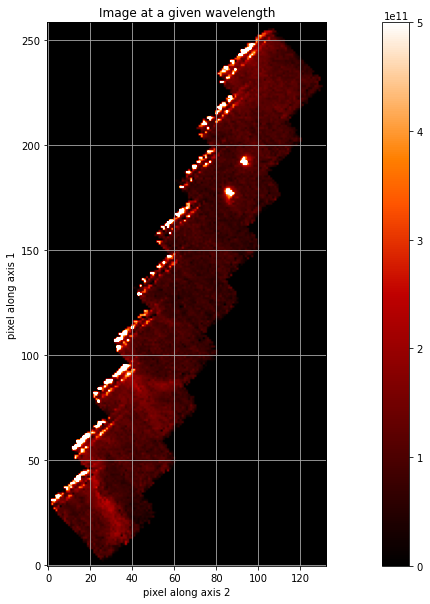

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(cube_nirspec170_data[650], cmap='gist_heat', origin='lower', vmin=0, vmax=5e11)
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.grid()
plt.title('Image at a given wavelength')

In [5]:
reduced_cube_nirspec170_data = cube_nirspec170_data[:1700,:,:]
bands, pix1, pix2 = reduced_cube_nirspec170_data.shape
print(f'Number of spectral bands: {bands}\nNumber of pixels: {pix1} x {pix2}\nTotal number of pixels {pix1*pix2}')

Number of spectral bands: 1700
Number of pixels: 259 x 133
Total number of pixels 34447


In [16]:
wavelength   = np.linspace(1.69997, 2.37317, bands)
pas = (2.2 - 1.7)/0.02
wavelength_bis = np.linspace(1.69997, 2.37317, 25)


In [33]:
mean_cube = np.zeros((25, pix1, pix2))
for l  in range(len(wavelength_bis)-1):
    wave1 = wavelength_bis[l] 
    wave2 = wavelength_bis[l+1]
    mean_cube[l] = np.mean(reduced_cube_nirspec170_data[l:l+1], axis=0)


In [34]:
hdu = fits.PrimaryHDU(mean_cube) 
hdu.writeto(f'nirspec_mean_cube_pos_170lp.fits', overwrite=True)

#### <span style='color:Salmon'> Defining functions for getting the spectra of a pixel
</span>

The NIRSpec data contains several cubes over a  $ 13"\times \ 26"$ field of view, each one spanning over a $3" \times\  3"$ on the sky


We remove the pixels that are zeros regardless the wavelength in order to retrieve the datacubes 


## Pretreatment of the data before the PCA

We remove the pixels that are zeros regardless the wavelength in order to retrieve the datacubes 


### Masking the all-wavelength zeros pixels 

#### <span style='color:Salmon'> Defining functions for masking 
</span>


#### <span style='color:DarkSeaGreen'>Test on the masked cubes </span> 


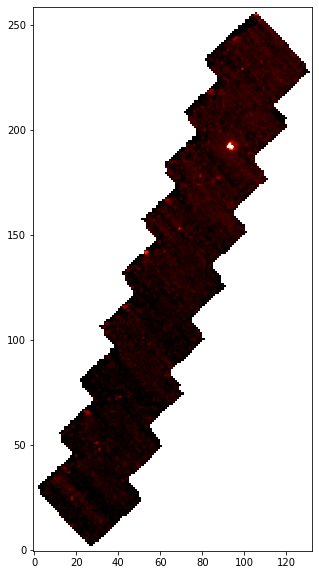

In [8]:
# To illustrate that our mask works, we display an image at a given wavelength 
#data = cube_nirspec170_data[2].copy()
#mask = compute_mask(cube_nirspec170_data)
#data[~mask]=np.nan
MaskedCubes            = masked_datacubes(reduced_cube_nirspec170_data)
plt.figure(figsize=(20,10))

plt.imshow(MaskedCubes[15], cmap='gist_heat', origin='lower', vmin=0, vmax=4e11)

If we have a closer look, we can see that there are outliers 

In [12]:
df = pd.DataFrame(MaskedCubes[0].ravel()/1e10)
df.describe()

0
count  10340.000000
mean       5.579810
std       13.473337
min        0.000000
25%        1.243593
50%        4.576496
75%        7.523623
max      381.260635

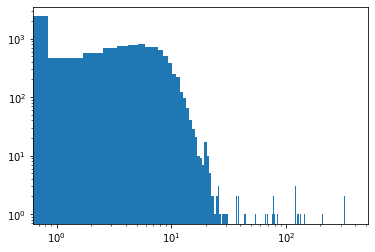

In [13]:
##### Histogram of an image #########
#df.hist(bins=100, logx=True)

fig, ax = plt.subplots()
plt.hist(df, bins=450)
ax.set_yscale('log')
ax.set_xscale('log')

To remove these outliers, we make a sigma clipping and substitute to these high values the medium. 

### Sigma Cipping to remove the outliers 
<div class="alert alert-info">We also have to remove any outliers in the datacubes that can affect the PCA procedure.
To do that we use **sigma_clip** from astropy.stats, we start by creating a mask to apply to the original data. We want the PCA to run over only on the non-zeros pixels along the wavelength's axis. To do so, we create a mask that take into account only the data cubes along the diagonale. 
</div>
    

#### <span style='color:IndianRed'> Defining functions for sigma clipping and the master masking
</span>

In [16]:
######## First Method ####################

#%%capture --no-display
#masks=[]
#for l in range(bands):
#    data_clipped = sigma_clip(MaskedCubes[l], sigma=3, maxiters=10, masked=True)
#    masks.append(data_clipped.mask)
#

####  <span style='color:Chocolate'> Getting the masked data ready for the PCA
</span> 

In [9]:
MaskedCubes            = masked_datacubes(reduced_cube_nirspec170_data)
ClippedCube, HyperMask = clipping_datacubes(MaskedCubes)
mask_allZeros          = compute_mask(reduced_cube_nirspec170_data)  
#mask = [mask_allZeros | HyperMask[l] for l in range(bands)] 
#masterMask = MasterMask(HyperMask, mask_allZeros, bands) # masque des éléments à retirer 
#maskNull = np.full((reduced_cube_nirspec170_data[0].shape), False) | mask_allZeros


In [10]:
masterMask =  np.full((pix1, pix2), False)
for x in range(pix1):
    for y in range(pix2):
        outliers = len(np.where(HyperMask[:,x,y])[0])
        if outliers >= 20:
            masterMask[x,y] = True 
        else:
            pass
masterMask[138,62] = False # 1 point 
masterMask[139,61] = False # 1 point voisin 
masterMask[173:180, 84:89]  = np.full((masterMask[173:180, 84:89].shape),False) # proplyd
masterMask[186:200, 89:100] = np.full((masterMask[186:200, 89:100].shape),False) # etoile
masterMask[213:223, 104:114] = np.full((masterMask[213:223, 104:114].shape),False) # truc a cote du bord 
masterMask[212,96] = False # 1 point 
### pixels restants ###
masterMask[176:178,89] = np.full((masterMask[176:178,89].shape),False)  
masterMask[192:195,100] = np.full((masterMask[192:195,100].shape),False)  
masterMask[200,95] = False # 1 point 
masterMask[212,96] = False # 1 point 
masterMask[220,103] = False # 1 point 
masterMask[233,95] = False # 1 point 
masterMask[239,99] = False # 1 point 
masterMask[178,89] = False # 1 point 
masterMask[195,100] = False # 1 point 
masterMask[199,109] = False # 1 point 
masterMask[222:223,113:114] = np.full((masterMask[222:223,113:114].shape),False)

masterMask[223,113] = False # 1 point 
masterMask[222,114] = False # 1 point 
masterMask[222,117] = False # 1 point
masterMask[224,118] = False # 1 point
masterMask = mask_allZeros | masterMask     

In [49]:
mask_tmp = np.zeros((masterMask.shape))
mask_tmp[np.where(masterMask==1)] = np.nan
hdu = fits.PrimaryHDU(mask_tmp) 
hdu.writeto('mask_tmp.fits', overwrite=True)


In [11]:
mask_file = get_pkg_data_filename('mask.fits')
TheMask = fits.getdata(mask_file)
TheMask = np.asarray(TheMask)

masterMask2 =np.full((masterMask.shape), False)
masterMask2[np.where(TheMask!=0)] = True
masterMask2 = masterMask2 | masterMask
#masterMask2[190:200, 90:100] = np.full((masterMask2[190:200, 90:100].shape),True)
#masterMask2[np.where(MasterMask==0)] = False 

In [17]:
test2D = apply_mask(MaskedCubes, masterMask2)
test3D = repliage(bands, pix1, pix2, test2D,masterMask2)
final3D, _ = clipping_datacubes(test3D)


In [16]:
cubes2D     = apply_mask(reduced_cube_nirspec170_data, masterMask2)
cubes3D     = repliage(bands, pix1, pix2, cubes2D, masterMask2)

####  <span style='color:Chocolate'> Some Test on the masterMask 
</span> 

In [36]:
#masterMask = ndimage.rotate(masterMask, 40, mode='constant')
#sx = ndimage.sobel(masterMask, axis=0, mode='constant')
#sy = ndimage.sobel(masterMask, axis=1, mode='constant')
#sob = np.hypot(sx, sy)
#plt.figure(figsize=(20,10))
#plt.imshow(sob, origin="lower")
#plt.axis('off')
#plt.title('Sobel filter', fontsize=20)

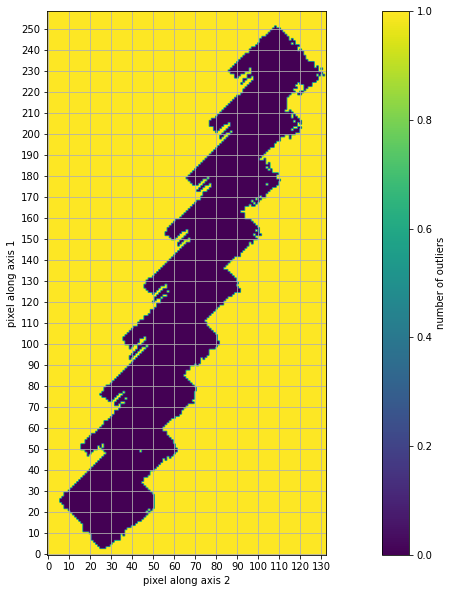

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(masterMask2,cmap='viridis', origin="lower", vmin=0, vmax=1)
plt.xlabel("pixel along axis 2")
plt.grid()
plt.ylabel("pixel along axis 1")
plt.colorbar(label='number of outliers')
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=30)
plt.savefig('masterMask2.png')

In [20]:
#plt.figure(figsize=(20,10))
#plt.imshow(masterMask,cmap='viridis', origin="lower")
#plt.xlabel("pixel along axis 2")
#plt.ylabel("pixel along axis 1")
#plt.colorbar(label='number of outliers')
#plt.locator_params(axis='x', nbins=20)
#plt.locator_params(axis='y', nbins=30)
#
#
#plt.grid()
##plt.savefig('Map_of_outliers.png')
#----------------------------------------------------------
#fig = px.imshow( masterMask, origin='lower', aspect="equal")
#fig.update_layout(showlegend=False, 
#                  xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 20))
#fig.show()

####  <span style='color:DarkSeaGreen'> Test the sigma clipping
</span> 

In [22]:
np.nanmin(cubes3D)

0.0

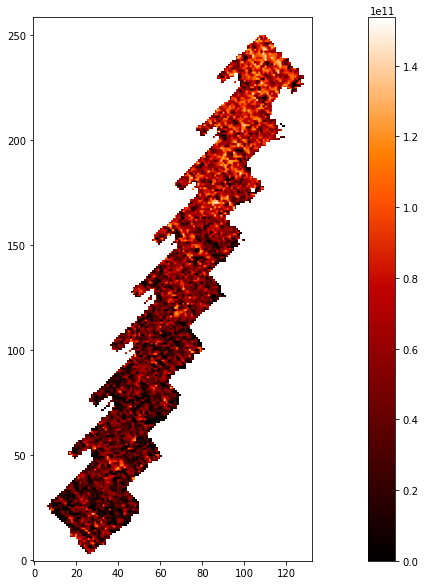

In [46]:
plt.figure(figsize=(20,10))
plt.imshow(final3D[0], cmap='gist_heat', origin='lower')
plt.colorbar()

In [22]:
cubes2D.shape

(8079, 1700)

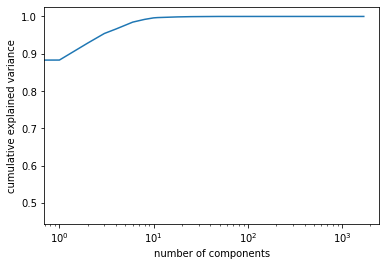

In [23]:
#cubes2D = StandardScaler().fit_transform(cubes2D)
pca = PCA(n_components=bands)
pca.fit(cubes2D)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xscale('log')
plt.ylabel('cumulative explained variance');

In [24]:
pca.components_.shape

(3663, 3663)

In [24]:
print((np.sort(pca.singular_values_)[::-1]))


[5.4368677e+16 5.0994271e+16 1.6948343e+16 ... 4.4577325e+11 4.4181583e+11
 4.3708639e+11]


In [199]:
test = np.ones((reduced_cube_nirspec170_data.shape))
for l in range(bands):
    test[l][masterMask] = 0

test2D = apply_mask(test,masterMask)
np.min(test)

In [27]:
for l in range(bands):
    MaskedCubes[l][~mask_allZeros] = 0
np.where(np.isnan(MaskedCubes))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [43]:
ClippedCube[HyperMask] = 0
for l in range(bands):
    ClippedCube[l][~mask_allZeros] = 0
np.where(np.isnan(ClippedCube))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [43]:
ClippedCube = reduced_cube_nirspec170_data.copy()
ClippedCube[:,masterMask2] = np.nan
a = apply_mask(cubes3D, masterMask2) 
b = apply_mask(ClippedCube, masterMask2)
np.where(a != b)

(array([], dtype=int64), array([], dtype=int64))

####  <span style='color:CornflowerBlue'> Mapping the outliers
</span>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


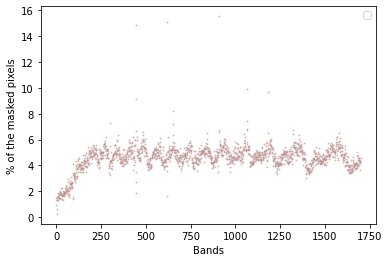

In [32]:
#wavelength        = np.linspace(1.69997, 3.15012, bands )
number_OF_outliers = []
for l in range(bands):
    number_OF_outliers.append(len(np.where(HyperMask[l,:,:])[0])/10340 * 100)
plt.scatter(x= range(bands), y= number_OF_outliers, s=1, color='rosybrown', alpha =0.5) 
plt.ylabel('% of the masked pixels')
plt.xlabel('Bands')
#plt.vlines(x= 1700, ymin=-1, ymax=20, alpha=0.5, label=f'$\lambda$ = {wavelength[1700]:.3f} $\mu m$')
#plt.vlines(x= 1970, ymin=-1, ymax=20, alpha=0.5, label=f'$\lambda$ = {wavelength[1970]:.3f} $\mu m$')
plt.legend()
#plt.savefig('number_of_outliers_per_bands.png')

In [33]:
outliers =[]
for x in range(pix1):
    for y in range(pix2):
        outliers.append(len(np.where(HyperMask[:,x,y])[0]))
        

In [34]:
outliers = np.asarray(outliers, dtype=float)
outliers = outliers.reshape((pix1, pix2))
outliers[mask_allZeros] = np.nan

In [ ]:

fig = px.line(x= wavelength, 
              y=[signatures_10[:, i] for i in range(10)], 
              color_discrete_sequence = px.colors.qualitative.G10, 
              labels = {'x': r' $\lambda \  \rm{in}\  \mu m $','y':"Amplitude"}, 
              title  = '10 elementary spectra', 
             )
fig.update_layout(showlegend=False, 
                  xaxis = dict(tickmode = 'linear', tick0 = 1.7, dtick = 0.1), 
                  #xaxis_title=r'$\sqrt{(n_\text{c}(t|{T_\text{early}}))}$',
                 )

  
fig.show()

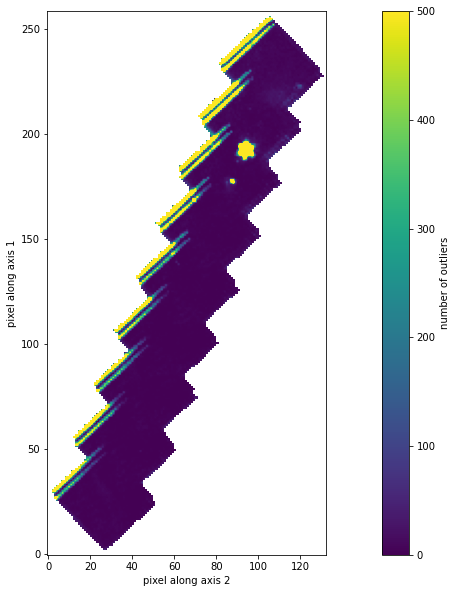

In [49]:
plt.figure(figsize=(20,10))
plt.imshow(outliers,cmap='viridis', origin="lower", vmin=0, vmax=500)
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar(label='number of outliers')
#plt.savefig('Map_of_outliers.png')

####  <span style='color:CornflowerBlue'> Having a look at the clipped Data
</span>

Text(0.5, 1.0, 'Image at a given wavelength')

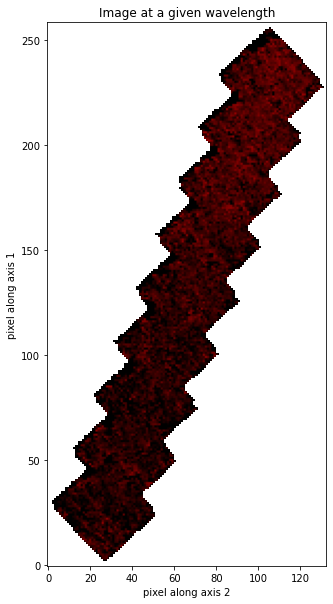

In [201]:
plt.figure(figsize=(20,10))
plt.imshow(ClippedCube[0], cmap='gist_heat', origin='lower', vmin= 0, vmax= 4e11 )
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.title('Image at a given wavelength')


In [51]:
df_clipped = pd.DataFrame(cubes3D[0].ravel()/1e10)
df_clipped.describe()
#print(f'{np.nanmedian(data_clipped[0]):.2e}')

0
count  8244.000000
mean      5.128523
std       3.781101
min       0.000000
25%       2.256165
50%       4.937187
75%       7.589407
max      57.354984

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

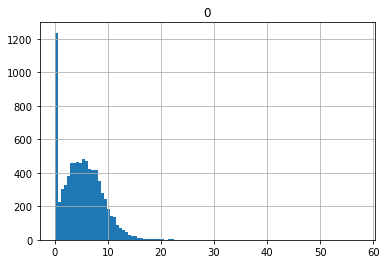

In [52]:
df_clipped.hist(bins=100)

In [22]:

# My pedestrian way of doing things ----- Method 1 ---------
#for k in range(pix2):
#    image = np.array(cube_nirspec170_data[:][:,k])
#    for i in range(pix1):
#        if len(np.where(image[:,i]==0)[0]) == bands:
#            mask = 

# On Wilfried's suggestion, a more numpy-optimized method --------- Method 2 ---------


In [23]:
#test = data[~np.isnan(data)]
#test = test.reshape((110,94))
#plt.figure(figsize=(25,10))
#plt.imshow(test, cmap='gist_heat', origin='lower')

We reshape the data and apply the mask over the wavelengths

In [24]:
# --------------------- TEST  ---------------------
#x, y  = np.arange(pix1), np.arange(pix2)
#X, Y  = np.meshgrid(y, x)
#output=[]
#for x, y in zip(X[mask],Y[mask]):
#        output.append(cube_nirspec170_data[:, y, x])
#
#cubes2D = np.asarray(output)
#print(X.shape)
#print(Y.shape)
#print(f'how X looks like:{X}')
#print(f'how Y looks like:{Y}')

Text(0.5, 1.0, 'Histogram of an image at $\\lambda$ = 1.7')

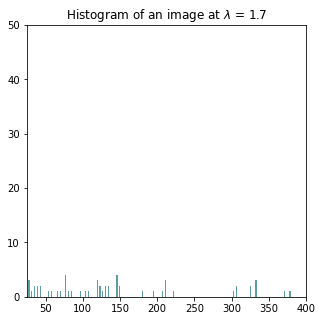

In [36]:
plt.figure(figsize=(5,5))
plt.hist([MaskedCubes[0].ravel()/1e10, ClippedCube[0].ravel()/1e10], color=["cadetblue", "peru"], bins=100)
plt.xlim([25, 400])
plt.ylim([0, 50])
plt.title(r'Histogram of an image at $\lambda$ = 1.7')

## PCA based on covariance 

We implement a PCA method on the masked data to retrieve the dimension of reduced spectral space *lacp*. But before, we have to make some pre-treatment on the data.

In [67]:
print(f'Number of components (traiing pixels): {cubes2D.shape[0]}')
print(f'Number of features (should be equal to number of bands): {cubes2D.shape[1]}')

Number of components (traiing pixels): 8079
Number of features (should be equal to number of bands): 1700


### Pre-treatment before the PCA ...


####  <span style='color:Chocolate'> Scaling the Data
</span> 

In [57]:
myScaler = StandardScaler()
cubes2D  = myScaler.fit_transform(cubes2D)



####  <span style='color:Chocolate'> Removing the mean value
</span> 

In [68]:
cubes2D_mean = np.mean(cubes2D, axis=0)
cubes2D -= cubes2D_mean

### PCA calculation 

In [69]:
#%time covariance_matrix=np.cov(cubes[:300].T)
if cubes2D.shape[1] == bands: 
    %time covariance_matrix=np.cov(cubes2D.T)
else:
    %time covariance_matrix=np.cov(cubes2D)
    

CPU times: user 1.01 s, sys: 42.9 ms, total: 1.05 s
Wall time: 167 ms


In [70]:
%time eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

CPU times: user 10.7 s, sys: 88.5 ms, total: 10.8 s
Wall time: 1.37 s



####  <span style='color:Chocolate'> Reducing the dimension
</span> 

In [71]:
ind=np.arange(0,len(eigen_values),1)
ind=[x for _,x in sorted(zip(eigen_values,ind))] #indexation par ordre croissant des vp
ind=ind[::-1]
sorted_eigen_values =eigen_values[ind] # sorted list in a decreasing order 
sorted_eigen_vectors=eigen_vectors[:,ind]
sorted_eigen_values[1699]

2.343044821100975e+19

####  <span style='color:CornflowerBlue'>Plotting the eigenvalues decrease
</span> 

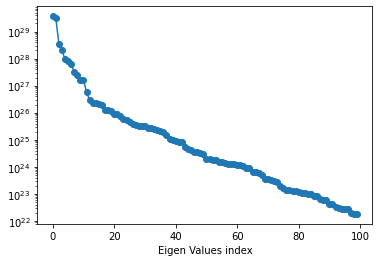

In [72]:
sorted_eigen_values_100=sorted_eigen_values[:100]
x=np.arange(0,len(sorted_eigen_values_100),1)
plt.yscale('log')
plt.plot(x,sorted_eigen_values_100,marker = 'o' )
plt.xlabel("Eigen Values index")
plt.ylabel("")
plt.show()

#### <span style='color:IndianRed'> Defining the explained variance ratio
</span>

In [73]:
def explained_variance_ratio(eigen_values, n_samples):
    
    """
    Compute the explained variance ratio which is the percentage of variance explained by each of the features.
    
    Parameters
    ----------
    eigen_values: list of singular values. MUST BE in a non-increasing order
    n_samples   : number of samples for the training 
    
    Returns
    -------
    explained_variance_ratio; percentage of explained variance
    
    """
    explained_variance  = eigen_values**2/(n_samples-1)
    total_variance      = explained_variance.sum()
    explained_var_ratio = explained_variance/total_variance
    return explained_var_ratio


####  <span style='color:CornflowerBlue'> Plotting the explained variance
</span> 

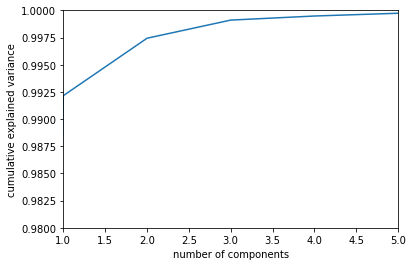

In [83]:
n_samples = cubes2D.shape[0]
explained_var_ratio = explained_variance_ratio(sorted_eigen_values, n_samples)
plt.plot(np.cumsum(explained_var_ratio))
plt.xlabel('number of components')
#plt.yscale('log')
plt.xlim(1,5)
plt.ylim(0.98,1)
plt.ylabel('cumulative explained variance');



####  <span style='color:CornflowerBlue'> Displaying the pricinpal signautres found by the PC
</span> 

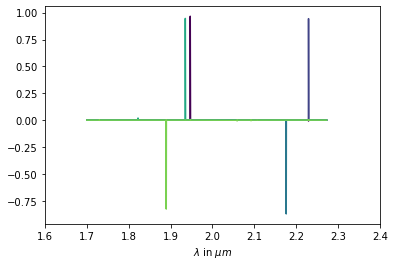

In [76]:
signatures_5 = sorted_eigen_vectors[:,:5] # on ne retient que les 10 premiers spectres 
wavelength    =  np.linspace(1.69997, 2.273, bands )
cmap = get_cmap('viridis')
for i in range(5):
     plt.plot(wavelength, signatures_5[:,i], c=cmap(i/5), label=f'Spectre #{i}')

#plt.plot([wavelength]*10, [signatures_10[:,i] for i in range(10)])
plt.xlabel(r'$\lambda$ in $\mu m$')
plt.xlim(1.6,2.4)
plt.savefig('5_spectres_pca.png')
plt.show()
#plt.plot(wavelength, signatures_10[:,8])

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js"></script>

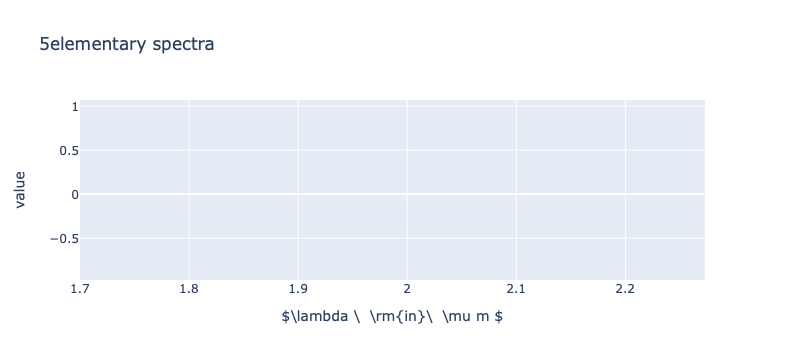

In [77]:
import plotly.offline as py
import plotly.express as px
fig = px.line(x= wavelength, 
              y=[signatures_5[:,i] for i in range(5)], 
              color_discrete_sequence = px.colors.qualitative.G10, 
              labels = {'x': r' $\lambda \  \rm{in}\  \mu m $','y':"Amplitude"}, 
              title  = '5elementary spectra', 
             )
fig.update_layout(showlegend=False, 
                  xaxis = dict(tickmode = 'linear', tick0 = 1.7, dtick = 0.1), 
                  #xaxis_title=r'$\sqrt{(n_\text{c}(t|{T_\text{early}}))}$',
                 )

  
fig.show()


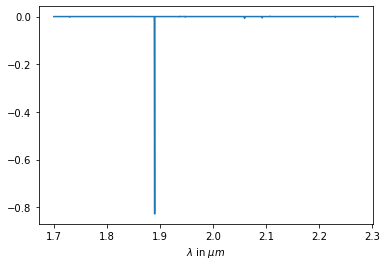

In [78]:
#plt.plot([wavelength, wavelength], [signatures_10[:,9], signatures_10[:,8] ])
plt.plot(wavelength, signatures_5[:,4])
plt.xlabel(r'$\lambda$ in $\mu m$')

plt.show()

The data can be projected onto a spectral subspace of $5$ dimension

## PCA based on SVD

We implement a PCA through a *Single Value Decomposition* (SVD) **scipy.linalg**, allowing us to retrieve the projection of the data cubes onto the spectral subspace of reduced dimension. 


#### Apply the PCA

In [12]:
nb_comp = 50
#asterMask = masterMask | mask_allZeros
V, Z, X_mean, S = pca_nirspec(reduced_cube_nirspec170_data, nb_comp, masterMask2,masked=True)
#V, Z, X_mean, S = pca_nirspec(final3D, nb_comp, masterMask2,masked=True)

In [13]:
Z_retro, Z_cube = retroprojection(V,Z,X_mean, masterMask2, bands)
Z_retro.shape

(1700, 8075)

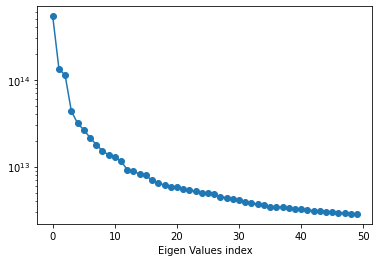

In [14]:
x=np.arange(0,len(S),1)

plt.yscale('log')
plt.plot(x,S,marker = 'o' )
plt.xlabel("Eigen Values index")
plt.show()

#### Saving and exporting into a FITS file 

In [83]:
hdu = fits.PrimaryHDU(Z) 
#hdu.writeto('nirspec_cube_pos_170lp_reduced_10_2.fits')

#### Checking the errors

In [47]:
# si Z est masqué il faut un data masqué
cubes2D = apply_mask(reduced_cube_nirspec170_data, masterMask2)
Yns = repliage(bands, pix1, pix2, cubes2D, masterMask2) 
error = check_pca(V,Z,X_mean, Yns, masterMask2, method='spectral')

# recuperer les vecteurs propores
#  mettre en couleurs le cube de sortie + cube exporter en fits  
# calculer l'erreur Y - retroprojection en spectre et en space => faire une carte cf theses 
# pour regularisation spatiale faire padding recopie mirroir

1700 259 133 (1700, 7977) (259, 133)


In [56]:
negative = np.where(Z_cube<0)
Z_cube[negative] = np.nan


Text(0.5, 1.0, 'Image at a given wavelength')

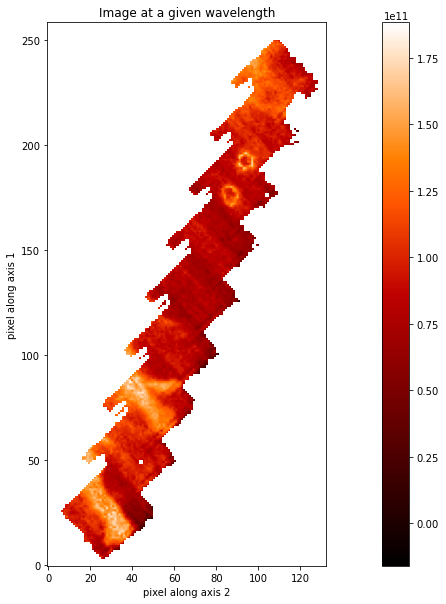

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(Z_cube[650], cmap='gist_heat', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.title('Image at a given wavelength')

In [57]:
hdu = fits.PrimaryHDU(Z_cube) 
hdu.writeto(f'nirspec_cube_pos_170lp_retroprojected_{nb_comp}_WITHStars.fits', overwrite=True)

In [155]:
np.nanmin(Z_cube)

3753495.9169921875

Text(0.5, 1.0, 'Image at a given wavelength')

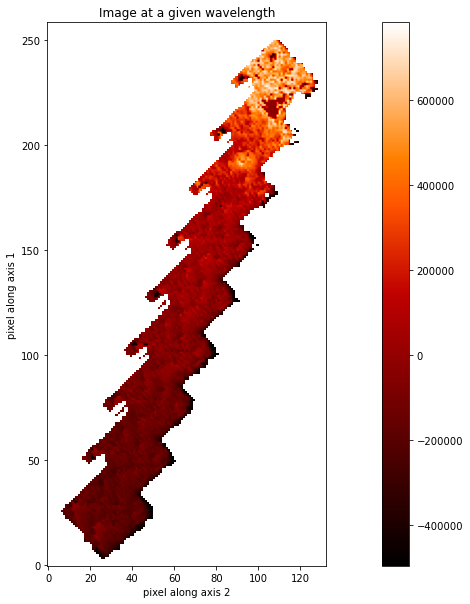

In [97]:
plt.figure(figsize=(20,10))
plt.imshow(Z[0], cmap='gist_heat', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.colorbar()
plt.title('Image at a given wavelength')

Text(0.5, 1.0, 'Image at a given wavelength')

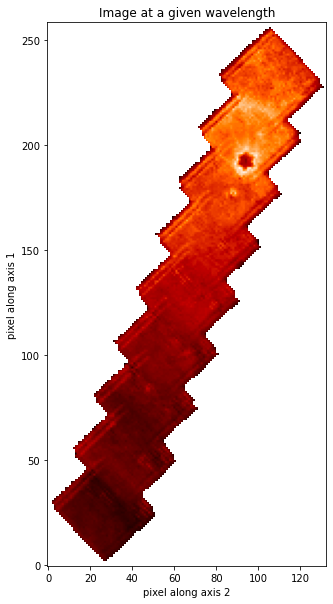

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(X_cube[200], cmap='gist_heat', origin='lower')
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.title('Image at a given wavelength')

In [89]:

error_df = pd.DataFrame(error)
error_df.describe()

0
count  8079.000000
mean      0.079925
std       0.031588
min       0.001592
25%       0.062456
50%       0.072966
75%       0.087849
max       0.324869

In [54]:
x,y     = np.arange(pix1), np.arange(pix2)
MX, MY  = np.meshgrid(y, x)
masked_image  = np.full((pix1, pix2), np.nan)
for x, y, z in zip(MX[~masterMask2], MY[~masterMask2], range(error.shape[0])):
    masked_image[ y, x] = error[z]    

Text(0.5, 1.0, 'Error along the wavelength axis')

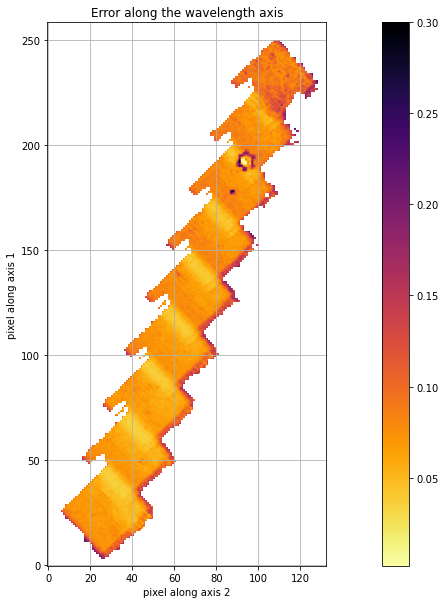

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(masked_image, cmap='inferno_r', origin='lower',vmax=0.3)
plt.xlabel("pixel along axis 2")
plt.ylabel("pixel along axis 1")
plt.grid()
plt.colorbar()
plt.title('Error along the wavelength axis')

In [56]:
max(error)

0.3248692756125671

In [41]:
test        = np.ones((cube_nirspec170_data.shape))
test[:, :100, :100]  = 1e9
Vtest,PCAtest,X_mean_test = pca_nirspec(test, 10, masked=True)

(34447, 3663)


In [34]:
df_Test = pd.DataFrame(test[10].ravel())
df_Test.describe()

0
count  3.444700e+04
mean   7.257526e+07
std    2.594418e+08
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+09

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

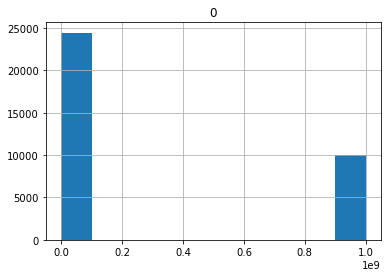

In [42]:
clippedTest = clipping_datacubes(test, maxiter=10)
df_clippedTest = pd.DataFrame(clippedTest[10].ravel())
df_clippedTest.hist()

In [43]:
mask      = compute_mask(test)  
errorTest = check_pca(Vtest, PCAtest, X_mean_test, clippedTest, mask, method='spectral') 
print(errorTest)

(3663, 34447)
[-5.93330311e-04 -7.41345746e-05  1.34607537e-03 ... -4.48046959e-06
 -4.48046959e-06  1.24714136e-06]


## Important Spectra 

### <span style='color:IndianRed'> Proplyd spectra
</span>

In [16]:
square_reduced_cube = resize(reduced_cube_nirspec170_data)
square_retro_cube   = resize(Z_cube)

In [17]:
center = PixCoord(86,177)
reg    = CirclePixelRegion(center, 4)
mask   = reg.to_mask()
#mask.to_image(shape)
proplyd = mask.cutout(square_reduced_cube[0])
#plt.imshow(mask.to_image(shape), cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower', vmin=)
np.ravel(proplyd)

array([8.24032707e+10, 1.39085988e+10, 5.52797348e+10, 7.56232028e+10,
       3.60878490e+10, 1.00000002e-16, 6.08997089e+10, 1.02567526e+11,
       9.26424515e+10, 1.11170560e+11, 1.15050185e+11, 9.10274970e+10,
       1.02171959e+11, 8.53348270e+10, 3.63291607e+10, 6.23387116e+10,
       8.89984778e+10, 6.63264420e+10, 8.00117801e+10, 9.08291441e+10,
       7.34810685e+10, 6.28683530e+10, 1.12139813e+11, 8.76176753e+10,
       6.89176986e+10, 8.27831009e+10, 6.78234808e+10, 8.23044833e+10,
       7.94118799e+10, 7.93368904e+10, 1.13557946e+11, 2.83960709e+10,
       9.83660134e+09, 4.13151969e+10, 2.80503603e+10, 9.48588790e+10,
       9.29388544e+10, 5.14572820e+10, 3.46681999e+10, 8.50363761e+10,
       5.73091267e+10, 8.13675233e+10, 9.95410821e+10, 8.19989955e+10,
       1.13566753e+11, 4.51483689e+10, 3.85886659e+10, 7.36119685e+10,
       3.60349860e+10, 6.31694909e+10, 9.69919283e+10, 8.69328077e+10,
       9.82505636e+10, 4.70819891e+09, 7.11733084e+10, 6.21729710e+10,
      

(150.0, 200.0)

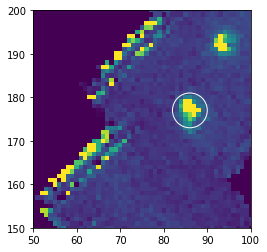

In [18]:
ax = plt.subplot(1, 1, 1)
ax.imshow(square_reduced_cube[650], cmap=plt.cm.viridis,
          interpolation='nearest', origin='lower', vmin=0, vmax=5e11)
ax.add_artist(reg.as_artist(facecolor='none', edgecolor='white'))
ax.set_xlim(50, 100)
ax.set_ylim(150, 200)

(0.0, 1000000000000.0)

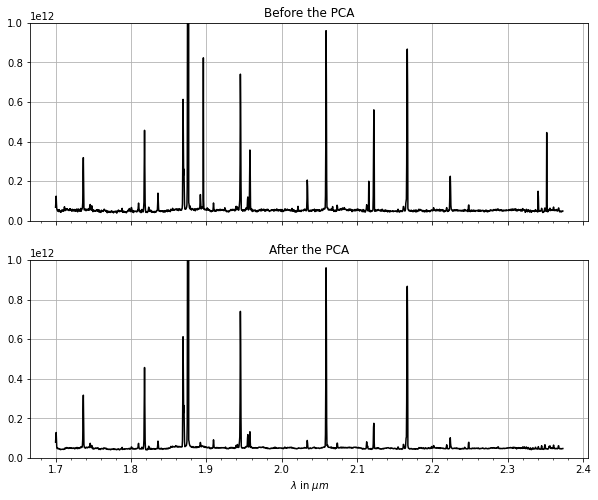

In [19]:
spectra_proplyd_beforePCA = plot_spectra(square_reduced_cube,reg)
spectra_proplyd_afterPCA  = plot_spectra(square_retro_cube,reg)
wavelength   = np.linspace(1.69997, 2.37317, bands)


fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True, sharey=True)
ax[0].plot(wavelength, spectra_proplyd_beforePCA, color='black')
ax[1].plot(wavelength, spectra_proplyd_afterPCA, color='black')
ax[0].set_title( "Before the PCA", loc='center')
ax[1].set_title("After the PCA")
ax[1].set_xlabel(r'$\lambda$ in $\mu m$')
ax[0].grid(True)
ax[1].grid(True)
ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].set_ylim(0, 1e12)
#plt.savefig('ProplydSpectra.png')




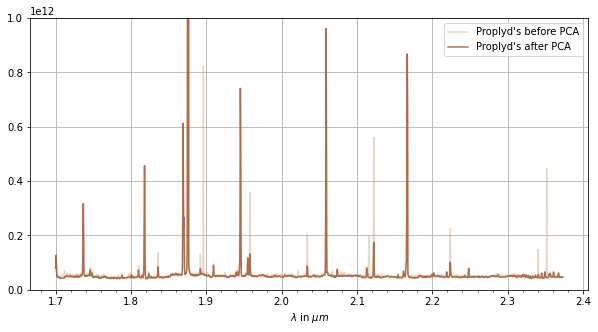

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(wavelength, spectra_proplyd_beforePCA, alpha=0.5, color='tan', label=f'Proplyd\'s before PCA')
ax.plot(wavelength, spectra_proplyd_afterPCA,  alpha=0.8, color='sienna', label=f'Proplyd\'s after PCA')
ax.set_xlabel(r'$\lambda$ in $\mu m$')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.02))
ax.set_ylim(0, 1e12)
plt.legend()
#ax[1].set_ylabel(0,5e12)
#plt.savefig('ProplydSpectra2.png')





### <span style='color:IndianRed'> Filaments spectra
</span>

In [27]:
center = PixCoord(28,28)
reg    = CirclePixelRegion(center, 3)
mask   = reg.to_mask()
#mask.to_image(shape)
filaments = mask.cutout(square_reduced_cube[0])
#plt.imshow(mask.to_image(shape), cmap=plt.cm.viridis,
#           interpolation='nearest', origin='lower', vmin=)
np.ravel(filaments)

array([7.82402109e+10, 1.00000002e-16, 1.00000002e-16, 1.00000002e-16,
       1.32993772e+10, 3.14775880e+10, 3.19129580e+10, 2.88052470e+10,
       4.08751718e+10, 1.00000002e-16, 1.00000002e-16, 1.00000002e-16,
       3.85262305e+10, 4.40861082e+10, 4.11412521e+10, 2.81399419e+10,
       1.66728827e+10, 1.60828559e+10, 1.81736742e+09, 2.90503045e+10,
       3.22348319e+10, 9.66875300e+10, 4.89668403e+10, 1.85716244e+10,
       1.53212365e+10, 2.40488776e+10, 5.73007954e+10, 4.99967058e+10,
       6.26229453e+10, 4.52555366e+09, 3.01395538e+10, 1.23845550e+10,
       1.00000002e-16, 1.00000002e-16, 3.43818486e+10, 4.71614382e+10,
       2.26466755e+10, 3.19200317e+10, 1.19446979e+10, 3.85073930e+10,
       1.00000002e-16, 1.96436705e+10, 2.52066058e+10, 7.17819003e+10,
       3.48122972e+10, 6.38262938e+09, 3.46663240e+10, 3.18472704e+08,
       1.54716744e+10])

(0.0, 50.0)

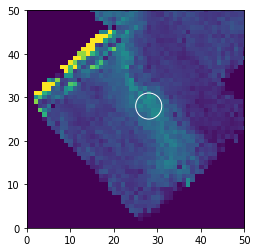

In [28]:
ax = plt.subplot(1, 1, 1)
ax.imshow(square_reduced_cube[650], cmap=plt.cm.viridis,
          interpolation='nearest', origin='lower', vmin=0, vmax=5e11)
ax.add_artist(reg.as_artist(facecolor='none', edgecolor='white'))
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)

(0.0, 500000000000.0)

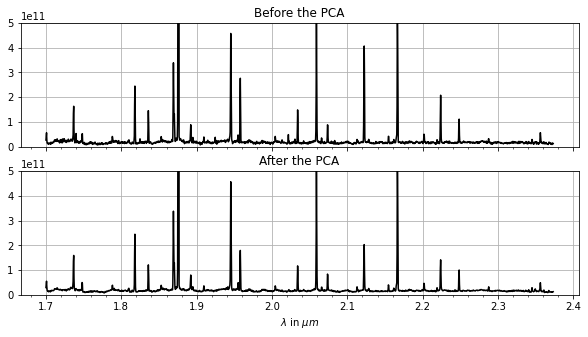

In [29]:
spectra_filaments_beforePCA = plot_spectra(square_reduced_cube,reg)
spectra_filaments_afterPCA  = plot_spectra(square_retro_cube,reg)
wavelength   = np.linspace(1.69997, 2.37317, bands)


fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].plot(wavelength, spectra_filaments_beforePCA, color='black')
ax[1].plot(wavelength, spectra_filaments_afterPCA, color='black')
ax[0].set_title( "Before the PCA", loc='center')
ax[1].set_title("After the PCA")
ax[1].set_xlabel(r'$\lambda$ in $\mu m$')
ax[0].grid(True)
ax[1].grid(True)
ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.02))
ax[0].set_ylim(0, 5e11)

#plt.savefig('filamentsSpectra.png')





In [26]:
from astropy.io import ascii
from astropy.table import Table

data = Table()
data['wavelength (in microns)'] = wavelength
data['flux'] = spectra_proplyd_afterPCA
ascii.write(data,"spectraProplyd.dat", overwrite=True )
#file = open("spectraProplyd.txt", "w")
#for index in range(len(wavelength)):
#    file.write(str(wavelength[index]) + " " + str(spectra_proplyd_afterPCA[index]) + "\n")
#file.close()

In [30]:

data = Table()
data['wavelength (in microns)'] = wavelength
data['flux'] = spectra_filaments_afterPCA
ascii.write(data,"spectrafilaments.dat", overwrite=True )
#file = open("spectraProplyd.txt", "w")
#for index in range(len(wavelength)):
#    file.write(str(wavelength[index]) + " " + str(spectra_proplyd_afterPCA[index]) + "\n")
#file.close()

In [31]:
data = Table()
data['wavelength (in microns)'] = wavelength
data['flux'] = spectra_proplyd_beforePCA
ascii.write(data,"spectraProplyd_beforePCA.dat", overwrite=True )
#file = open("spectraProplyd.txt", "w")
#for index in range(len(wavelength)):
#    file.write(str(wavelength[index]) + " " + str(spectra_proplyd_afterPCA[index]) + "\n")
#file.close()

In [32]:
data = Table()
data['wavelength (in microns)'] = wavelength
data['flux'] = spectra_filaments_beforePCA
ascii.write(data,"spectrafilaments_beforePCA.dat", overwrite=True )
#file = open("spectraProplyd.txt", "w")
#for index in range(len(wavelength)):
#    file.write(str(wavelength[index]) + " " + str(spectra_proplyd_afterPCA[index]) + "\n")
#file.close()